In [ ]:
IMAGE_SIZE = 256
EPOCHS = 2000
NOISE_SIZE = 10
NUM_NEW_IMAGES = 100
DATASET_FOLDER1='/content/normal'
DATASET_FOLDER='/content/pnemonia'

BATCH_SIZE = 64
LR_D = 0.0002 # Paper
LR_G = 0.0002 # Paper

BETA1 = 0.9 # Default
EPSILON = 0.001 # Default
LEAK_RELU_APLPHA = 0.2 # Paper
KERNEL_INITIALIZER='glorot_uniform' # Default

In [ ]:
from datetime import datetime
import os
from glob import glob
from IPython import display
import imageio
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import PIL
from PIL import Image
import pytz
tz_NY = pytz.timezone('America/New_York')
import random
from scipy import ndarray
import skimage as sk
from skimage import io
from skimage import util
from skimage import transform
import tensorflow as tf
from tensorflow.keras import layers
import time

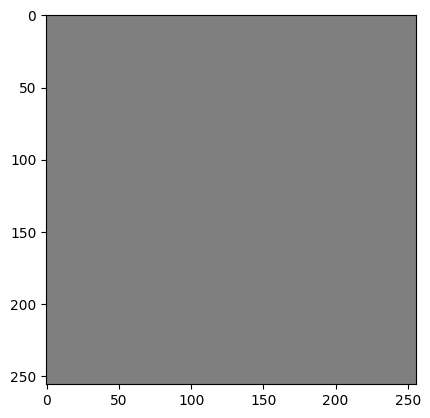

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(32*32*512, use_bias=False, input_shape=(NOISE_SIZE,)))
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.ReLU())

    model.add(layers.Reshape((32, 32, 512)))
    assert model.output_shape == (None, 32, 32, 512) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False,
                                    kernel_initializer=KERNEL_INITIALIZER))
    assert model.output_shape == (None, 64, 64, 256)
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False,
                                    kernel_initializer=KERNEL_INITIALIZER))
    assert model.output_shape == (None, 128, 128, 128)
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh',
                                    kernel_initializer=KERNEL_INITIALIZER))
    assert model.output_shape == (None, 256, 256, 3)

    return model

generator = make_generator_model()

# Use the (as yet untrained) generator to create an image.
noise = tf.random.normal([1, NOISE_SIZE])
generated_image = generator(noise, training=False)

generated_image2 = generated_image[0].numpy() * 127.5 + 127.5

plt.imshow(generated_image2.astype('uint8'))

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[256, 256, 3],
                                    kernel_initializer=KERNEL_INITIALIZER))
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.LeakyReLU(alpha=LEAK_RELU_APLPHA))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same',
                                    kernel_initializer=KERNEL_INITIALIZER))
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.LeakyReLU(alpha=LEAK_RELU_APLPHA))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
#Use the (as yet untrained) discriminator to classify the generated images as real or fake.
#The model will be trained to output positive values for real images, and negative values for fake images.
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-5.590925e-05]], shape=(1, 1), dtype=float32)


In [ ]:
def show_samples(sample_images):

    print("len(sample_images): ", len(sample_images))
    print("len(sample_images): ", sample_images[0].shape)

    figure, axes = plt.subplots(1, len(sample_images), figsize = (50, 50))

    print("figure: ", figure)
    print("axes: ", axes)

    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[index]
        axis.imshow(image_array)

    plt.show()
    plt.close()

In [ ]:
def show_image_custom(input_image):
    fig = plt.figure(figsize=(4,4))

    plt.imshow(input_image)

    plt.axis('off')

    plt.show()

In [ ]:
def summarize_epoch(epoch, d_losses, g_losses, save_image=True):

    fig, ax = plt.subplots()
    plt.plot(d_losses, label='Discriminator', alpha=0.6)
    plt.plot(g_losses, label='Generator', alpha=0.6)
    plt.title("Losses")
    plt.legend()
    if save_image:
        plt.savefig("losses_" + str(epoch) + ".png")
    plt.show()
    plt.close()

In [ ]:
def generate_and_save_images(model, epoch, test_input, save_image=True):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      generated_image2 = predictions[i].numpy() * 127.5 + 127.5
      plt.imshow(generated_image2.astype('uint8'))

      plt.axis('off')

  if save_image:
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
def show_samples2(sample_images):
    figure, axes = plt.subplots(1, len(sample_images), figsize = (50, 50))

    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[index]
        image_array = image_array.numpy() * 127.5 + 127.5
        axis.imshow(image_array.astype(np.uint8))

    plt.show()
    plt.close()

In [ ]:
import random
import os
import skimage as sk
from skimage import io, transform
import numpy as np

# Function to crop and pad images
def TF_crop_pad(x, n_pixels, pad_mode):
    # First pad image by n_pixels on each side
    padded = np.pad(x, ((n_pixels, n_pixels), (n_pixels, n_pixels), (0, 0)), mode=pad_mode)

    # Crop the padded image to the original size
    cropped = padded[n_pixels:-n_pixels, n_pixels:-n_pixels, :]

    return cropped

# Dictionary of the transformations we defined earlier
available_transformations = {
    'rotate': lambda x: transform.rotate(x, angle=random.uniform(-45, 45)),
    'vertical_flip': np.flip,
    'horizontal_flip': np.flip,
    'vertical_and_horizontal_flip': sk.util.img_as_ubyte,
    'TF_crop_pad': lambda x: TF_crop_pad(x, n_pixels=10, pad_mode='constant')  # Adjust parameters as needed
}

# Folder path containing the original images
DATASET_FOLDER = DATASET_FOLDER


# Number of new images to generate
NUM_NEW_IMAGES = 100

# Find all file paths from the folder
images = [os.path.join(DATASET_FOLDER, f) for f in os.listdir(DATASET_FOLDER) if os.path.isfile(os.path.join(DATASET_FOLDER, f))]

num_generated_files = 0
while num_generated_files < NUM_NEW_IMAGES:
    # Random image from the folder
    image_path = random.choice(images)

    # Read image as a two-dimensional array of pixels
    image_to_transform = sk.io.imread(image_path)

    # Random number of transformations to apply
    num_transformations_to_apply = random.randint(1, len(available_transformations))

    num_transformations = 0
    transformed_image = None
    while num_transformations < num_transformations_to_apply:
        # Random transformation to apply for a single image
        key = random.choice(list(available_transformations))
        transformed_image = available_transformations[key](image_to_transform)
        num_transformations += 1

    new_file_path = f'{DATASET_FOLDER}/augmented_image_{num_generated_files}.jpg'

    # Write image to the disk
    io.imsave(new_file_path, transformed_image.astype(np.uint8))
    num_generated_files += 1

<ipython-input-45-90edeedf6a91>:58: UserWarning: /content/pnemonia/augmented_image_0.jpg is a low contrast image
  io.imsave(new_file_path, transformed_image.astype(np.uint8))
<ipython-input-45-90edeedf6a91>:58: UserWarning: /content/pnemonia/augmented_image_2.jpg is a low contrast image
  io.imsave(new_file_path, transformed_image.astype(np.uint8))
<ipython-input-45-90edeedf6a91>:58: UserWarning: /content/pnemonia/augmented_image_7.jpg is a low contrast image
  io.imsave(new_file_path, transformed_image.astype(np.uint8))
<ipython-input-45-90edeedf6a91>:58: UserWarning: /content/pnemonia/augmented_image_9.jpg is a low contrast image
  io.imsave(new_file_path, transformed_image.astype(np.uint8))
<ipython-input-45-90edeedf6a91>:58: UserWarning: /content/pnemonia/augmented_image_12.jpg is a low contrast image
  io.imsave(new_file_path, transformed_image.astype(np.uint8))
<ipython-input-45-90edeedf6a91>:58: UserWarning: /content/pnemonia/augmented_image_13.jpg is a low contrast image
  io.

Input: (170, 256, 256, 3)
len(sample_images):  5
len(sample_images):  (256, 256, 3)
figure:  Figure(5000x5000)
axes:  [<Axes: > <Axes: > <Axes: > <Axes: > <Axes: >]


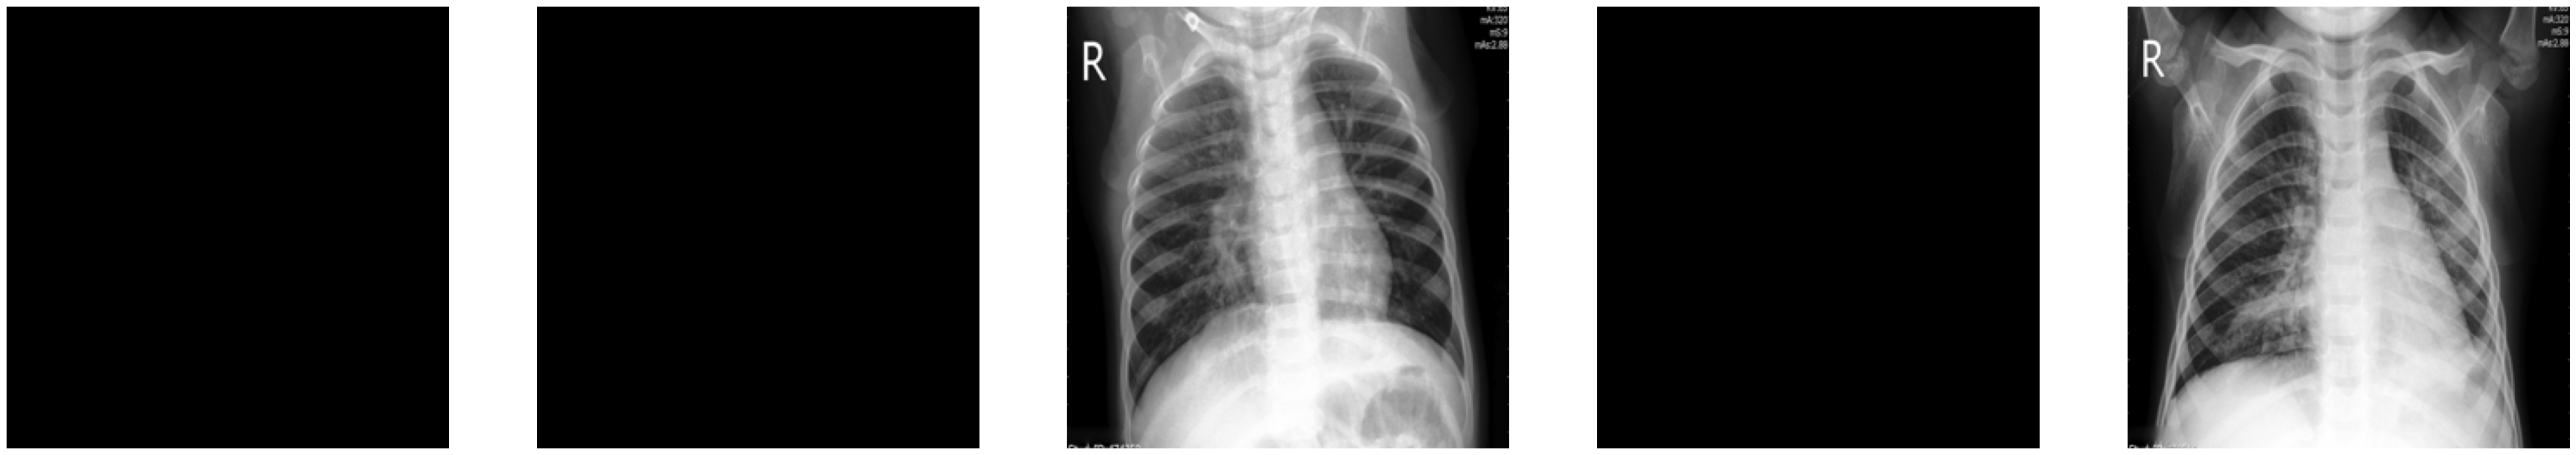

In [ ]:
import numpy as np
from PIL import Image
from glob import glob

DATASET_FOLDER = '/content/pnemonia/'
IMAGE_SIZE = 256
BATCH_SIZE = 32

# Load image files from the specified directory
input_images = np.asarray([np.asarray(
    Image.open(file)
    .resize((IMAGE_SIZE, IMAGE_SIZE))
    ) for file in glob(DATASET_FOLDER + '*.jpg')])  # Adjust the file extension based on your image format

print("Input: " + str(input_images.shape))

np.random.shuffle(input_images)

train_images = input_images.reshape(input_images.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5

BUFFER_SIZE = input_images.shape[0]
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

sample_images = input_images[:5]
show_samples(sample_images)

In [ ]:
import random
import os
import skimage as sk
from skimage import io, transform
import numpy as np

# Function to crop and pad images
def TF_crop_pad(x, n_pixels, pad_mode):
    # First pad image by n_pixels on each side
    padded = np.pad(x, ((n_pixels, n_pixels), (n_pixels, n_pixels), (0, 0)), mode=pad_mode)

    # Crop the padded image to the original size
    cropped = padded[n_pixels:-n_pixels, n_pixels:-n_pixels, :]

    return cropped

# Dictionary of the transformations we defined earlier
available_transformations = {
    'rotate': lambda x: transform.rotate(x, angle=random.uniform(-45, 45)),
    'vertical_flip': np.flip,
    'horizontal_flip': np.flip,
    'vertical_and_horizontal_flip': sk.util.img_as_ubyte,
    'TF_crop_pad': lambda x: TF_crop_pad(x, n_pixels=10, pad_mode='constant')  # Adjust parameters as needed
}

# Folder path containing the original images
DATASET_FOLDER = DATASET_FOLDER1


# Number of new images to generate
NUM_NEW_IMAGES = 100

# Find all file paths from the folder
images = [os.path.join(DATASET_FOLDER, f) for f in os.listdir(DATASET_FOLDER) if os.path.isfile(os.path.join(DATASET_FOLDER, f))]

num_generated_files = 0
while num_generated_files < NUM_NEW_IMAGES:
    # Random image from the folder
    image_path = random.choice(images)

    # Read image as a two-dimensional array of pixels
    image_to_transform = sk.io.imread(image_path)

    # Random number of transformations to apply
    num_transformations_to_apply = random.randint(1, len(available_transformations))

    num_transformations = 0
    transformed_image = None
    while num_transformations < num_transformations_to_apply:
        # Random transformation to apply for a single image
        key = random.choice(list(available_transformations))
        transformed_image = available_transformations[key](image_to_transform)
        num_transformations += 1

    new_file_path = f'{DATASET_FOLDER}/augmented_image_{num_generated_files}.jpg'

    # Write image to the disk
    io.imsave(new_file_path, transformed_image.astype(np.uint8))
    num_generated_files += 1

<ipython-input-47-d6ac17579216>:58: UserWarning: /content/normal/augmented_image_1.jpg is a low contrast image
  io.imsave(new_file_path, transformed_image.astype(np.uint8))
<ipython-input-47-d6ac17579216>:58: UserWarning: /content/normal/augmented_image_5.jpg is a low contrast image
  io.imsave(new_file_path, transformed_image.astype(np.uint8))
<ipython-input-47-d6ac17579216>:58: UserWarning: /content/normal/augmented_image_6.jpg is a low contrast image
  io.imsave(new_file_path, transformed_image.astype(np.uint8))
<ipython-input-47-d6ac17579216>:58: UserWarning: /content/normal/augmented_image_9.jpg is a low contrast image
  io.imsave(new_file_path, transformed_image.astype(np.uint8))
<ipython-input-47-d6ac17579216>:58: UserWarning: /content/normal/augmented_image_11.jpg is a low contrast image
  io.imsave(new_file_path, transformed_image.astype(np.uint8))
<ipython-input-47-d6ac17579216>:58: UserWarning: /content/normal/augmented_image_13.jpg is a low contrast image
  io.imsave(new_f

Input: (170, 256, 256, 3)
len(sample_images):  5
len(sample_images):  (256, 256, 3)
figure:  Figure(5000x5000)
axes:  [<Axes: > <Axes: > <Axes: > <Axes: > <Axes: >]


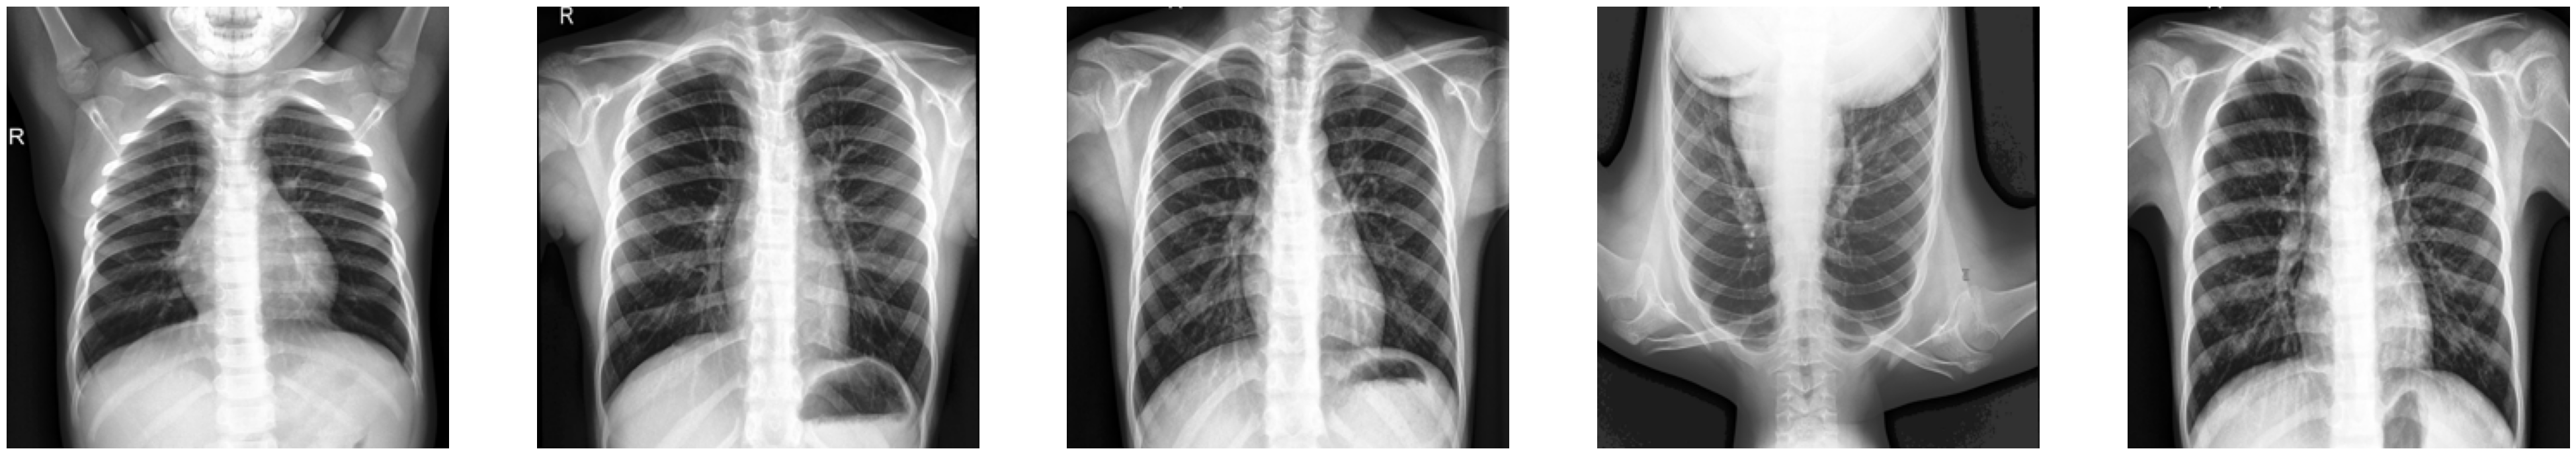

In [ ]:
import numpy as np
from PIL import Image
from glob import glob

DATASET_FOLDER = '/content/normal/'
IMAGE_SIZE = 256
BATCH_SIZE = 32

# Load image files from the specified directory
input_images = np.asarray([np.asarray(
    Image.open(file)
    .resize((IMAGE_SIZE, IMAGE_SIZE))
    ) for file in glob(DATASET_FOLDER + '*.jpg')])  # Adjust the file extension based on your image format

print("Input: " + str(input_images.shape))

np.random.shuffle(input_images)

train_images = input_images.reshape(input_images.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5

BUFFER_SIZE = input_images.shape[0]
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

sample_images = input_images[:5]
show_samples(sample_images)

In [ ]:
import matplotlib.pyplot as plt

def show_samples1(images, labels=None):
    plt.figure(figsize=(10, 2))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow((images[i] + 1) / 2)  # Assuming images are in the range [-1, 1]
        plt.axis('off')
        if labels is not None:
            plt.title(f'Label: {labels[i]}')
    plt.show()

Input images shape: (340, 256, 256, 3)
Labels shape: (340,)


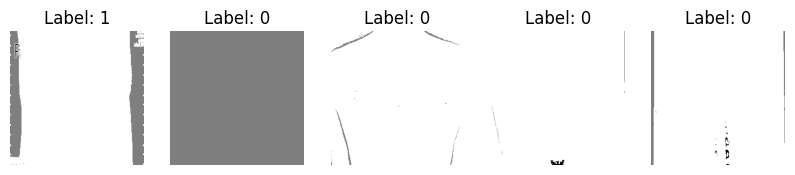

In [ ]:
import numpy as np
from PIL import Image
from glob import glob
import tensorflow as tf

IMAGE_SIZE = 256
BATCH_SIZE = 32

# Load image files from the specified directories
folders = ['/content/normal/', '/content/pnemonia/']
all_input_images = []
all_labels = []

# Manually assign labels
labels_mapping = {'normal': 0, 'pnemonia': 1}

for folder in folders:
    label = labels_mapping[folder.split('/')[-2]]  # Extract label from folder name
    images = np.asarray([np.asarray(
        Image.open(file)
        .resize((IMAGE_SIZE, IMAGE_SIZE))
        ) for file in glob(folder + '*.jpg')])  # Adjust the file extension based on your image format

    labels = np.full((images.shape[0],), label)  # Create labels for each image

    all_input_images.append(images)
    all_labels.append(labels)

# Combine images and labels from both folders
input_images = np.concatenate(all_input_images, axis=0)
labels = np.concatenate(all_labels, axis=0)

print("Input images shape:", input_images.shape)
print("Labels shape:", labels.shape)

np.random.seed(42)  # Set seed for reproducibility
shuffle_indices = np.arange(input_images.shape[0])
np.random.shuffle(shuffle_indices)

input_images = input_images[shuffle_indices]
labels = labels[shuffle_indices]

train_images = input_images.reshape(input_images.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5

BUFFER_SIZE = input_images.shape[0]
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Show samples if you have the `show_samples` function
sample_images = input_images[:5]
sample_labels = labels[:5]
show_samples1(sample_images, sample_labels)


In [ ]:
import numpy as np
from PIL import Image
from glob import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

# Load images and labels from the specified directories
folders = ['/content/normal/', '/content/pnemonia/']
all_input_images = []
all_labels = []

# Manually assign labels
labels_mapping = {'normal': 0, 'pnemonia': 1}

for folder in folders:
    label = labels_mapping[folder.split('/')[-2]]  # Extract label from folder name
    images = np.asarray([np.asarray(
        Image.open(file)
        .resize((IMAGE_SIZE, IMAGE_SIZE))
        ) for file in glob(folder + '*.jpg')])  # Adjust the file extension based on your image format

    labels = np.full((images.shape[0],), label)  # Create labels for each image

    all_input_images.append(images)
    all_labels.append(labels)

# Combine images and labels from both folders
input_images = np.concatenate(all_input_images, axis=0)
labels = np.concatenate(all_labels, axis=0)

print("Input images shape:", input_images.shape)
print("Labels shape:", labels.shape)

np.random.seed(42)  # Set seed for reproducibility
shuffle_indices = np.arange(input_images.shape[0])
np.random.shuffle(shuffle_indices)

input_images = input_images[shuffle_indices]
labels = labels[shuffle_indices]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(input_images, labels, test_size=0.2, random_state=42)

# Build the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification (normal/pnemonia)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))


Input images shape: (340, 256, 256, 3)
Labels shape: (340,)
Epoch 1/2000
9/9 [==============================] - 19s 2s/step - loss: 4200.5874 - accuracy: 0.4853 - val_loss: 243.3112 - val_accuracy: 0.6912
Epoch 2/2000
9/9 [==============================] - 17s 2s/step - loss: 654.4775 - accuracy: 0.6654 - val_loss: 326.9465 - val_accuracy: 0.7500
Epoch 3/2000
9/9 [==============================] - 25s 3s/step - loss: 101.1762 - accuracy: 0.8199 - val_loss: 157.2910 - val_accuracy: 0.7353
Epoch 4/2000
9/9 [==============================] - 16s 2s/step - loss: 53.7868 - accuracy: 0.8566 - val_loss: 154.5145 - val_accuracy: 0.7794
Epoch 5/2000
9/9 [==============================] - 16s 2s/step - loss: 20.9095 - accuracy: 0.8860 - val_loss: 120.4979 - val_accuracy: 0.8235
Epoch 6/2000
9/9 [==============================] - 17s 2s/step - loss: 5.0552 - accuracy: 0.9191 - val_loss: 113.9228 - val_accuracy: 0.8088
Epoch 7/2000
9/9 [==============================] - 17s 2s/step - loss: 2.7976 

3/3 [==============================] - 2s 386ms/step
Accuracy: 0.8382
Precision: 0.8158
Recall: 0.8857
ROC AUC: 0.9091


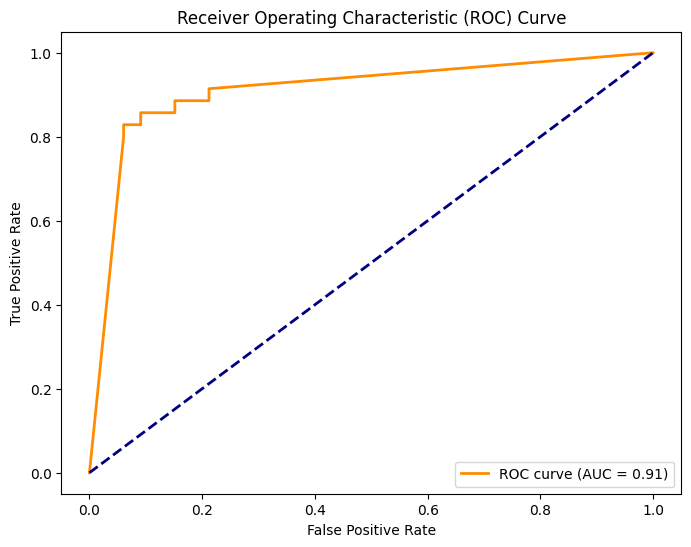

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc_curve = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_curve:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
